# Location Grouping Multivariate LSTM



By Nida Copty, India Tory, Emily Nguyen, Thomas Nguyen


This notebook represents the next evolution in our LSTM modeling journey, building upon the foundation laid by the univariate LSTM model and the multivariate LSTM model utilizing city-wide occupancy rate data. Now, our focus shifts to training the model on individual shelter data, aiming to capture unique patterns inherent to each shelter.

To avoid overfitting, we employ a strategic approach to encode shelter data using one-hot vectors. With over 200 shelters, a direct one-hot encoding would lead to excessive feature dimensions, risking over-parameterization. Thus, we devise a grouping strategy, leveraging geolocation information to cluster shelters with similar characteristics into cohesive groups.

The key challenge lies in determining the optimal number of clusters for grouping shelters. We adopt a data-driven approach, employing k-means clustering with varying centroids. Through varying methods of analysis, we aim to discern the ideal number of centroids that best capture the nuanced patterns within the shelter data.

### Imports

In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy as dc
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import random
import seaborn as sns

### Dataset Load

In [ ]:
#Occupancy Rate (Output Data):
data_23 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv"
data_22 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv"
data_21 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv"
data_24 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Daily shelter overnight occupancy.csv"
links = [data_24, data_23, data_22, data_21]

#Weather Data
data_w_23 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2023_P1D.csv"
data_w_24 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2024_P1D.csv"
data_w_22 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2022_P1D.csv"
data_w_21 = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2021_P1D.csv"
links_weather = [data_w_24, data_w_23, data_w_22, data_w_21]

#Housing
data_housing = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Housing.csv"

#Crisis helpline
data_crisis = r"/content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Persons_in_Crisis_Calls_for_Service_Attended_Open_Data.csv"

Class to read and report on errors when reading csv files.

In [ ]:
def load_csv_to_pandas(file_path):
    try:
        # Load CSV file into a pandas dataFrame
        df = pd.read_csv(file_path, header=0, low_memory=False, encoding='unicode_escape')
        print("Number of rows in the dataFrame:", file_path, len(df))
        return df
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None
    except Exception as e:
        print("An error occurred:", str(e))
        return None

This function below is to convert all the datasets of different features into a singular panda dataframes and also a hashmap containing individual shelter datas.

In [ ]:
def loadData(output_data, weather_data, housing, crisis):

    #-------Output Data-------#
    #Loading up the links to the output dataset
    for i in range(len(output_data)):
        output_data[i] = load_csv_to_pandas(output_data[i])

    #Dropping irrelevant columns for output datasets
    for i in range(len(output_data)):
        #print(output_data[i])
        output_data[i] = output_data[i].drop(columns = ['_id', 'ORGANIZATION_ID', 'SHELTER_ID', 'LOCATION_ID', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_NAME', 'SECTOR', 'PROGRAM_MODEL','OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'SERVICE_USER_COUNT', 'CAPACITY_FUNDING_BED', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'CAPACITY_FUNDING_ROOM', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS'])
        output_data[i]['OCCUPANCY_DATE'] = output_data[i]['OCCUPANCY_DATE']
        output_data[i]['OCCUPANCY_DATE'] =  pd.to_datetime(output_data[i]['OCCUPANCY_DATE'], format='%Y-%m-%d')

    #Joining the Output data together
    big_data = output_data[0]
    for i in range(1,len(output_data)):
        big_data = pd.concat([big_data, output_data[i]], ignore_index = True)

    #Determine the max and min date in the dataset to create a date vector to fill out empty values
    max_date = big_data['OCCUPANCY_DATE'].max()
    min_date = big_data['OCCUPANCY_DATE'].min()
    date_range = pd.date_range(start=min_date, end=max_date, freq = 'D')
    date_df = pd.DataFrame({'OCCUPANCY_DATE': date_range})

    #-------Weather Data-------#

    #loading up the links to the weather dataset
    for i in range(len(weather_data)):
        weather_data[i] = load_csv_to_pandas(weather_data[i])

    #Dropping irrelevant columns for weather datasets
    for i in range(len(weather_data)):
        weather_data[i] = weather_data[i].drop(columns = ['ï»¿"Longitude (x)"', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year', 'Month', 'Day', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days Flag', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag',
        'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'])
        weather_data[i]['Date/Time'] = weather_data[i]['Date/Time'].astype(str)
        weather_data[i]['Date/Time'] = pd.to_datetime(weather_data[i]['Date/Time'])

    #Joining the Weather data together
    big_weather = weather_data[0]
    for i in range(1, len(weather_data)):
        big_weather = pd.concat([big_weather, weather_data[i]], ignore_index = True)

    #Cut down all data with dates that is bigger than the biggest date and smaller than the smallest date with an output
    big_weather = big_weather[big_weather['Date/Time'] <= max_date]
    big_weather = big_weather[big_weather['Date/Time'] >= min_date]

    #Fill out datasets' entries w no data w 0
    big_weather = big_weather.fillna(0)

    #Changing non output dataset's date column to 'OCCUPANCY_DATE'
    big_weather = big_weather.rename(columns = {'Date/Time': 'OCCUPANCY_DATE'})

    #-------Housing Data-------#

    #loading up housing data
    housing = load_csv_to_pandas(housing)

    #Dropping irrelevant columns for housing dataset
    housing = housing[housing['GEO'] == 'Toronto, Ontario']
    housing = housing[housing['New housing price indexes'] == 'Total (house and land)']
    housing = housing.drop(columns = ['GEO', 'DGUID', 'New housing price indexes', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'])
    housing = housing.rename(columns = {housing.columns[0]: 'OCCUPANCY_DATE'})
    housing["OCCUPANCY_DATE"] = pd.to_datetime(housing["OCCUPANCY_DATE"])
    housing = housing[housing["OCCUPANCY_DATE"] >= min_date]
    housing = housing[housing["OCCUPANCY_DATE"] <= max_date].reset_index(drop=True)
    housing = pd.merge(housing, date_df, on = 'OCCUPANCY_DATE', how = 'outer')
    housing = housing.sort_values(by='OCCUPANCY_DATE').reset_index(drop=True)
    housing = housing.ffill()

    #-------Crisis Data-------#

    #Loading the crisis dataset
    crisis = load_csv_to_pandas(crisis)

    #Analyize Data
    crisis = crisis.drop(columns = ['ï»¿OBJECTID', 'EVENT_ID', 'EVENT_YEAR', 'EVENT_MONTH', 'EVENT_DOW', 'EVENT_HOUR', 'DIVISION', 'OCCURRENCE_CREATED', 'APPREHENSION_MADE', 'MCIT_ATTEND', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140'])
    crisis = crisis.rename(columns = {'EVENT_DATE': 'OCCUPANCY_DATE'})
    crisis = crisis.groupby(['OCCUPANCY_DATE', 'EVENT_TYPE']).size().unstack(fill_value=0)
    crisis.reset_index(inplace=True)
    crisis = crisis.rename_axis(None, axis=1)
    crisis['OCCUPANCY_DATE'] = pd.to_datetime(crisis['OCCUPANCY_DATE']).dt.date
    crisis['OCCUPANCY_DATE'] = pd.to_datetime(crisis['OCCUPANCY_DATE'])
    crisis = crisis[crisis["OCCUPANCY_DATE"] >= min_date]
    crisis = crisis[crisis["OCCUPANCY_DATE"] <= max_date]
    crisis = pd.merge(date_df, crisis, on='OCCUPANCY_DATE', how='left')

    #-------Final Data Prep-------#

    #Merge the datasets together through date
    big_data = pd.merge(big_data, big_weather, on = 'OCCUPANCY_DATE', how = 'inner')
    big_data = pd.merge(big_data, housing, on = 'OCCUPANCY_DATE', how = 'inner')
    big_data = pd.merge(big_data, crisis, on = 'OCCUPANCY_DATE', how = 'inner')

    big_data = big_data.sort_values(by='OCCUPANCY_DATE')

    #Placing the bed and room occupancy column last
    room_occupancy = big_data.pop('OCCUPANCY_RATE_ROOMS')
    bed_occupancy = big_data.pop('OCCUPANCY_RATE_BEDS')
    big_data['OCCUPANCY_RATE_BEDS'] = bed_occupancy
    big_data['OCCUPANCY_RATE_ROOMS'] = room_occupancy

    grouped_data = big_data.groupby('PROGRAM_ID')
    shelter_data_frames = {}
    for shelter_id, shelter_group in grouped_data:
        shelter_data_frames[shelter_id] = shelter_group
        shelter_data_frames[shelter_id]['OCCUPANCY_DATE'] = pd.to_datetime(shelter_data_frames[shelter_id]['OCCUPANCY_DATE'])

    big_data.reset_index(inplace=True)
    big_data = big_data.drop(columns = ['index'])

    return big_data, shelter_data_frames

Running the function to get the dataframe and hashmap

In [ ]:
dataframe, iso_data = loadData(links.copy(), links_weather.copy(), data_housing, data_crisis)

Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/Daily shelter overnight occupancy.csv 11459
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv 48345
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv 49478
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv 50944
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2024_P1D.csv 366
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI | Lets Solve IT/Datasets/en_climate_daily_ON_6158355_2023_P1D.csv 365
Number of rows in the dataFrame: /content/drive/MyDrive/RBC | Borealis AI 

### Determining Compatible Shelters and their Coordinates

To determine compatible shelters, we will calculate the lat and long coordinate of the shelters and see if they are in the Toronto zone. If they are, we will save them and their coordinates for k-means calculations. The function below will get the coordinates of the shelter given its address.

In [ ]:
def get_coordinates(address):
    geolocator = Nominatim(user_agent="my_geocoder", timeout=10000)
    location = geolocator.geocode(str(address) + ", Ontario, Canada", country_codes='CA')
    if location:
        return location.latitude, location.longitude
    else:
        return None

We will run a loop to calculate the coordinate of each of the shelters and see if they are in the Toronto zone.

In [ ]:
location_x = []
location_y = []

shel_location = {}

for i in iso_data:

  if len(iso_data[i]) >= 150:

    coordinates = get_coordinates(iso_data[i]['LOCATION_ADDRESS'].iloc[0])
    try:
      if coordinates[0] > 43.4 and coordinates[0] < 44 and coordinates[1] < -79.4 and coordinates[1] > -80.2:

        location_x.append(coordinates[0])
        location_y.append(coordinates[1])
        shel_location[i] = [coordinates[0], coordinates[1]]
    except:
      pass

#Data will give us the coordinates of each of the viable shelters
data = []
for i in shel_location:
  data.append(shel_location[i])

We can plot the cooridinates of the shelters. The function below achieves that.

In [ ]:
def plot_coord(x, y):

	# Creating the plot
	plt.figure(figsize=(8, 6))
	plt.plot(y, x, 'o', color='blue')
	plt.title('Toronto Shelters Location')
	plt.xlabel('Longitude')
	plt.ylabel('Latitude')
	plt.show()

We can run the function to get the graph

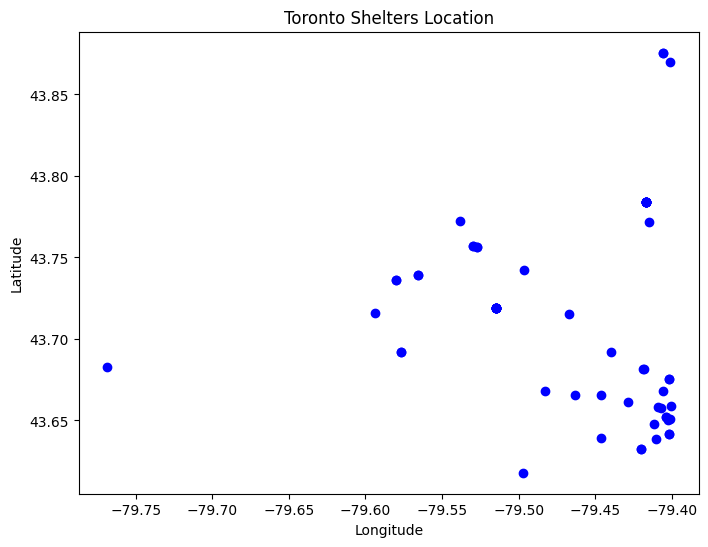

In [ ]:
plot_coord(location_x, location_y)

As a reference, here is the location of the shelters mapped on an actual map of the GTA area. A visual inspection will show the resemblance between the graph above and the map below.

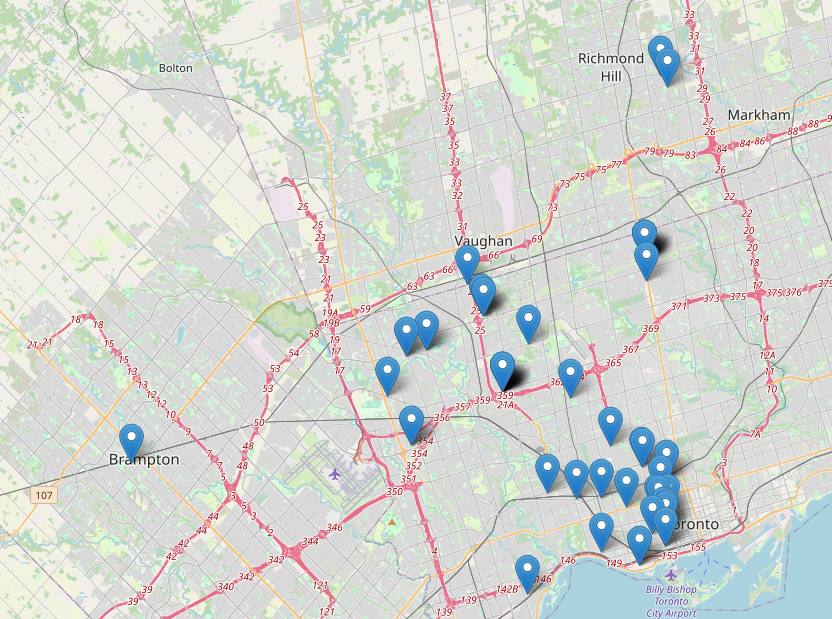

### Applying K-means

The next step is to apply k-means to the coordinates. The number of centroids will be increased from 2 to 8, and from there analysis can be applied to determine the optimal number of centroids used. The function below is for the k-means itself.

In [ ]:
def k_means(data,k):

	#---Initialization---#
	# Cluster centroids placement are picked at a data point
	cens_cord = []
	ran_lst = []
	while len(set(ran_lst)) < k:
		num = np.random.randint(0,len(data))
		ran_lst.append(num)
	ran_lst = set(ran_lst)

	for i in range(0,k):
		cens_cord.append(data[ran_lst.pop()])
	#---End of Initialization---#

	#Repeating loop
	stor_cord = []
	temporary = []
	for i in range(len(cens_cord)):
		for z in range(len(cens_cord[0])):
			temporary.append(cens_cord[i][z])
		stor_cord.append(temporary)
		temporary = []

	while True:
		cen_closest = []
		dist = []
		dist_2 = []
		temp = []
		sum_0 = 0

		#---Cluster Assignment Step---#
		for d in range(0,k):
			for i in range(len(data)): #569
				for z in range(len(data[i])): #30
					sum_0 += (data[i][z] - cens_cord[d][z]) ** 2
				dist.append(np.sqrt(sum_0))
				sum_0 = 0

		for i in range(0,k):
			for z in range(len(data)):
				temp.append(dist.pop(0))
			dist_2.append(temp)
			temp = []

		for i in range(len(data)):
			cen_closest.append(find_least(dist_2,i))
		#---End of Cluster Assignment---#

		#---Move Centroid---#
		mean = []
		for i in range(len(data[0])):
			mean.append(0)

		mean_counter = 0
		for i in range(0,k):
			q = 0
			while q < len(data):
				if cen_closest[q] == i:
					mean_counter += 1
					for p in range(len(data[0])):
						mean[p] += data[q][p]
				q += 1
			if mean_counter != 0:
				for o in range(len(data[0])):
					mean[o] = float(mean[o])/mean_counter
				cens_cord[i] = mean
				mean = []
				for l in range(len(data[0])):
					mean.append(0)
				mean_counter = 0
		#--- End of Move Centroid---#

		#---Terminating Conditions---#
		if cens_cord == stor_cord:
			return cens_cord,cen_closest
		else:
			temporary = []
			stor_cord = []
			for i in range(len(cens_cord)):
				for z in range(len(cens_cord[0])):
					temporary.append(cens_cord[i][z])
				stor_cord.append(temporary)
				temporary = []
		#---End of Terminating Conditions---#

def find_max(data, i):
	#i is the index of row
	#this function is to find the max for the specified row
	max_1 = 0
	for z in range(len(data)):
		if data[z][i] > max_1:
			max_1 = data[z][i]
	return max_1

def find_least(dist,i):
	lst = []
	for z in range(len(dist)):
		lst.append(dist[z][i])
	return lst.index(min(lst))

As a reference, we will show a graph where the centroids used are 5

In [ ]:
cens_coord, cens_index = k_means(data, 5)

#Grabbing the centroids coordinates
cens_x = []
cens_y = []
for i in cens_coord:
  cens_x.append(i[0])
  cens_y.append(i[1])

The function below plots the centroids and shelters

In [ ]:
def plot_shelters_n_centroids(cx, cy, sx, sy):

  # Creating the plot
  plt.figure(figsize=(8, 6))
  plt.plot(cy, cx, 'o', color='blue', label = 'Centroid')
  plt.plot(sy, sx, '.', color='red', label = 'Shelter')
  plt.title('Shelters coordinate with their grouping')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.legend()
  plt.show()

Calling that function above will give us the graph

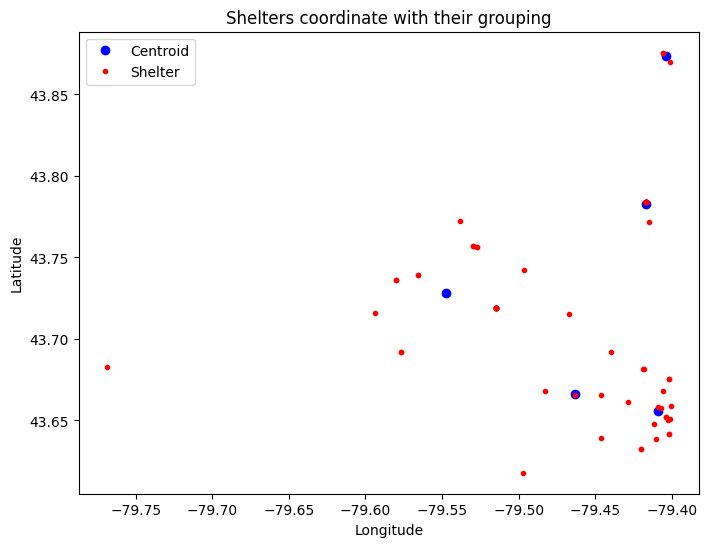

In [ ]:
plot_shelters_n_centroids(cens_x, cens_y, location_x, location_y)

### Distortions Analysis

One of the metrics used for grouping is distortions. The objective of this section is to determine the distortions for each number of centroids used. As a rule, the "elbow" rule to be exact, the number of centroids used is at the "elbow" of the distortions curve. We will run a loop calling k means from 2 to 9 centroids to calculate the distortions of each number of centroids.

In [ ]:
x_axis = []
y_axis = []
cens_index_dist_map = {}
cens_coord_dist_map = {}

for i in range(2,10):

  cens_coord,cens_index = k_means(data,i)
  cens_index_dist_map[i] = cens_index
  cens_coord_dist_map[i] = cens_coord
  x_axis.append(i)
  dist_s = 0
  distortions = 0
  for z in range(0,i):
    dist_s = 0
    q = 0
    while q < len(data):
      if cens_index[q] == z:
        for s in range(len(data[0])):
          dist_s += (data[q][s] - cens_coord[z][s])**2
        distortions += dist_s
      q += 1
  distortions = distortions/len(data)
  y_axis.append(distortions)

We can plot the distortions as a function of number of centroids. The graph below achieves that.

In [ ]:
def plot_distortions(x, y):

	# Creating the plot
	plt.figure(figsize=(8, 6))
	plt.plot(y, x, 'o', color='blue')
	plt.title('Distortions as a function of the number of centroids')
	plt.xlabel('Number of Centroids (k)')
	plt.ylabel('Distortions')
	plt.show()

Calling that function will give us the graph

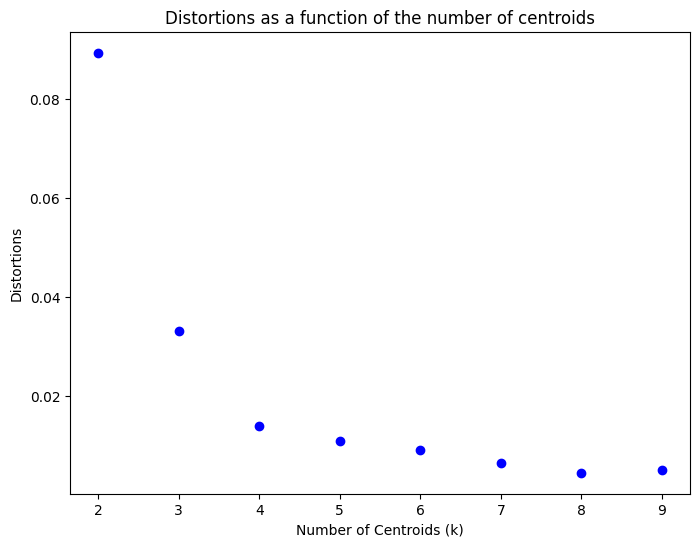

In [ ]:
plot_distortions(y_axis, x_axis)

### Correlation Analysis

We will now perform correlation analysis on the grouped shelters for each different number of centroids. The first step is break down which shelter belongs to which grouping for a specific number of centroids. The function below achieves that

In [ ]:
def shel_grouping(cens_index):
  shel_group = {}
  for i,n in enumerate(shel_location):
    shel_group[n] = cens_index[i]
  return shel_group

def shel_indexing(shel_group):
  index_shel = {}
  for i in shel_group:
    try:
      index_shel[shel_group[i]].append(i)
    except:
      index_shel[shel_group[i]] = [i]

  return index_shel

Then we can get the correlation matrix for each of the grouping. From the correlation matrix, we can calculate a total correlation score acress all grouping. Thus achieving the total score based on that number of centroids for our correlation anaylis. The function below achives that

In [ ]:
def correlation_score(index_shel, z):
  df_list = []
  mean = 0
  try:
    for i in index_shel[z]:
      if iso_data[i]['OCCUPANCY_RATE_ROOMS'].isna().all():
        df_ = iso_data[i].rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
      else:
        df_ = iso_data[i].rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})
      df_list.append(df_[['OCCUPANCY_DATE','PROGRAM_ID', 'OCCUPIED_PERCENTAGE']])

    concatenated_df = pd.concat(df_list, ignore_index=True)
    pivot_df = concatenated_df.pivot_table(index='OCCUPANCY_DATE', columns='PROGRAM_ID', values='OCCUPIED_PERCENTAGE')
    correlation_matrix = pivot_df.corr()
    column_sums = correlation_matrix.sum()/len(index_shel[z])
    mean = column_sums.mean()
  except:
    pass
  return mean

Let's run a loop through k-means again with varying number of centroids, but now we can calculate the correlation score for each number of centroids used

In [ ]:
correlation_point = []
cens_index_corr_map = {}
cens_coord_corr_map = {}

#Loop through k-means from 2 to 7 centroids
for i in range(2,10):

  #run k_means
  cens_coord,cens_index = k_means(data,i)

  cens_index_corr_map[i] = cens_index
  cens_coord_corr_map[i] = cens_coord

  #Loop through all groupings to get correlation point
  sum_cor = 0
  for z in range(1,i + 1):
    shel_group = shel_grouping(cens_index)
    index_shel = shel_indexing(shel_group)
    sum_cor += correlation_score(index_shel, z - 1)

  #Divide by number of groupings to get the average correlation point
  sum_cor /= i
  correlation_point.append(sum_cor)

We can graph the distortions and correlation as a function of the number of centroids used. The function below achieves that

In [ ]:
def plot_correlation_and_distortions(correlation, x_distortions, y_distortions):

    # Create figure and axes for subplots
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot correlation values
    ax.bar(range(2, len(correlation) + 2), correlation, color='orange', label='Correlation')

    # Add labels and title
    ax.set_xlabel('Number of Centroids (k)')
    ax.set_ylabel('Correlation')
    ax.set_title('Correlation and Distortions')

    # Create second y-axis for distortion values
    ax2 = ax.twinx()

    # Plot distortion values
    ax2.plot(range(2, len(x_distortions) + 2), y_distortions, 'o', color='blue', label='Distortions')

    # Add labels for the second y-axis
    ax2.set_ylabel('Distortions')

    # Show legend
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

Calling the function will give us the graph

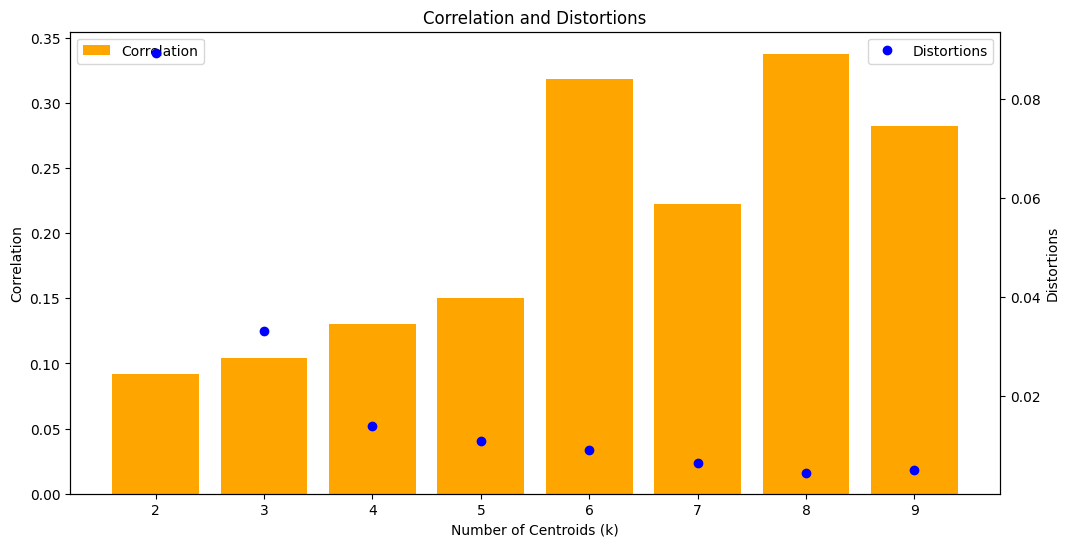

In [ ]:
plot_correlation_and_distortions(correlation_point, x_axis, y_axis)

### Distortions and Correlation Analysis Result and Grouping Scheme

It can be seen in the graph above that using the distortion geolocation grouping scheme, the number of centroids to use is 4 since that is where the location of the "elbow" is. As for the correlation geolocation grouping scheme, the number of centroids to use is 8 since that is where the correlation is the highest.

In [ ]:
print("Shelter Grouping for Distortion Scheme:")
print(shel_indexing(shel_grouping(cens_index_dist_map[4])))
print('\n')
print("Shelter Grouping for Correlation Scheme:")
print(shel_indexing(shel_grouping(cens_index_corr_map[8])))

Shelter Grouping for Distortion Scheme:
{3: [11794, 11798, 11799, 11831, 11871, 11891, 11895, 11971, 12011, 12053, 12231, 12251, 12471, 12711, 13451, 14251, 14631, 14651, 14671, 14931, 15171, 15711, 16131, 16151, 16371], 2: [11815, 12254, 14051, 15811, 15871, 16191, 16192, 16193, 16271, 16311, 16671, 16691, 17011, 17012, 17211, 17212], 1: [11911, 12274, 13932, 15111, 15112, 16194, 16911, 17191, 17691, 17771, 17772, 17791, 17811], 0: [12252, 12291, 12292, 14571, 14572, 16111, 16891, 16892]}


Shelter Grouping for Correlation Scheme:
{4: [11794, 11871, 11971, 13451, 14651, 14671, 16371], 7: [11798, 11799, 11831, 11891, 11895, 12251, 12471, 12711, 14251, 14631, 14931], 1: [11815, 12291, 12292, 14051, 14571, 14572, 15811, 15871, 16111, 16191, 16192, 16193, 16271, 16311, 16671, 16691, 16891, 16892, 17011, 17012, 17211, 17212], 6: [11911, 15111, 15112, 16194, 16911, 17191, 17771, 17772, 17791, 17811], 0: [12011, 12053, 12231, 12254, 15171], 2: [12252], 3: [12274, 13932, 17691], 5: [15711, 16

Another way to record this by simply showing the grouping index of each shelter itself

In [ ]:
print("Shelter Grouping for Distortion Scheme:")
print(shel_grouping(cens_index_dist_map[4]))
print('\n')
print("Shelter Grouping for Correlation Scheme:")
print(shel_grouping(cens_index_corr_map[8]))

Shelter Grouping for Distortion Scheme:
{11794: 3, 11798: 3, 11799: 3, 11815: 2, 11831: 3, 11871: 3, 11891: 3, 11895: 3, 11911: 1, 11971: 3, 12011: 3, 12053: 3, 12231: 3, 12251: 3, 12252: 0, 12254: 2, 12274: 1, 12291: 0, 12292: 0, 12471: 3, 12711: 3, 13451: 3, 13932: 1, 14051: 2, 14251: 3, 14571: 0, 14572: 0, 14631: 3, 14651: 3, 14671: 3, 14931: 3, 15111: 1, 15112: 1, 15171: 3, 15711: 3, 15811: 2, 15871: 2, 16111: 0, 16131: 3, 16151: 3, 16191: 2, 16192: 2, 16193: 2, 16194: 1, 16271: 2, 16311: 2, 16371: 3, 16671: 2, 16691: 2, 16891: 0, 16892: 0, 16911: 1, 17011: 2, 17012: 2, 17191: 1, 17211: 2, 17212: 2, 17691: 1, 17771: 1, 17772: 1, 17791: 1, 17811: 1}


Shelter Grouping for Correlation Scheme:
{11794: 4, 11798: 7, 11799: 7, 11815: 1, 11831: 7, 11871: 4, 11891: 7, 11895: 7, 11911: 6, 11971: 4, 12011: 0, 12053: 0, 12231: 0, 12251: 7, 12252: 2, 12254: 0, 12274: 3, 12291: 1, 12292: 1, 12471: 7, 12711: 7, 13451: 4, 13932: 3, 14051: 1, 14251: 7, 14571: 1, 14572: 1, 14631: 7, 14651: 4, 14671

The grouping above will be listed as the grouping used moving forward. Stating it outright here will helping for testing in other scripts since we will not have to rebuild any existing code infrastructure. As a visual reference, we will build coordinate plots to show the grouping scheme visually for both distortions and correlation.

We will start by showing the distortion grouping plot. The first step is to map the shelter coordinates and categorize them into their respective grouping.

In [ ]:
dist_shel_mapper = shel_indexing(shel_grouping(cens_index_dist_map[4]))
dist_grouping_plot = {}
for i in dist_shel_mapper:
  for z in dist_shel_mapper[i]:
    try:
      dist_grouping_plot[i]['x'].append(shel_location[z][0])
      dist_grouping_plot[i]['y'].append(shel_location[z][1])
    except:
      dist_grouping_plot[i] = {'x':[shel_location[z][0]], 'y':[shel_location[z][1]]}

cens_x, cens_y = [], []
for i in cens_coord_dist_map[4]:
  cens_x.append(i[0])
  cens_y.append(i[1])

The next thing to do is to plot it, the function below achieves that.

In [ ]:
def plot_dist_grouping(dist_grouping_plot, cens_x, cens_y):
  plt.figure(figsize=(8, 6))

  for i in dist_grouping_plot:
    plt.plot(dist_grouping_plot[i]['y'], dist_grouping_plot[i]['x'], '.')
  plt.plot(cens_y, cens_x, 'o', color='blue')
  plt.title('Shelters coordinate with their GeoLocation Distortion grouping')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.show()

We can call the function to see the graph

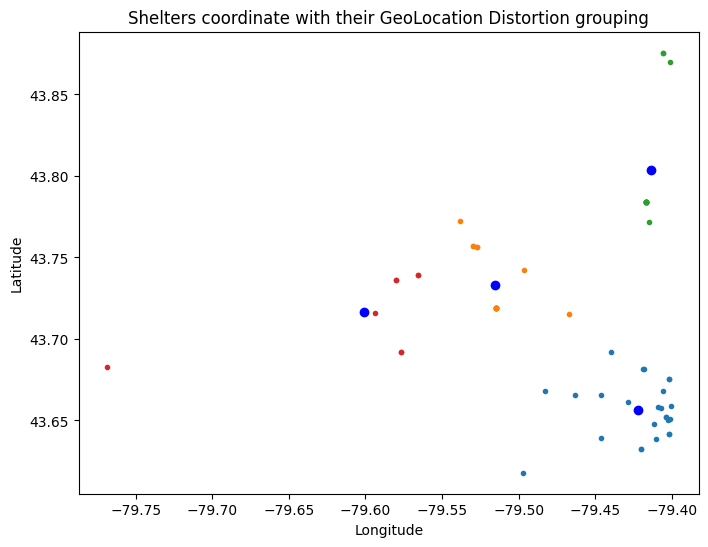

In [ ]:
plot_dist_grouping(dist_grouping_plot, cens_x, cens_y)

Lets repeat that process for Correlation Grouping Plot. Lets start with mapping the shelter coordinates and categorizing them into their respective grouping.

In [ ]:
corr_shel_mapper = shel_indexing(shel_grouping(cens_index_corr_map[8]))
corr_grouping_plot = {}
for i in corr_shel_mapper:
  for z in corr_shel_mapper[i]:
    try:
      corr_grouping_plot[i]['x'].append(shel_location[z][0])
      corr_grouping_plot[i]['y'].append(shel_location[z][1])
    except:
      corr_grouping_plot[i] = {'x':[shel_location[z][0]], 'y':[shel_location[z][1]]}

cens_x, cens_y = [], []
for i in cens_coord_corr_map[8]:
  cens_x.append(i[0])
  cens_y.append(i[1])

We can plot it the function below

In [ ]:
def plot_corr_grouping(corr_grouping_plot, cens_x, cens_y):
  plt.figure(figsize=(8, 6))

  for i in corr_grouping_plot:
    plt.plot(corr_grouping_plot[i]['y'], corr_grouping_plot[i]['x'], '.')
  plt.plot(cens_y, cens_x, 'o', color='blue')
  plt.title('Shelters coordinate with their GeoLocation Correlation grouping')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.show()

Call the function to see the plot

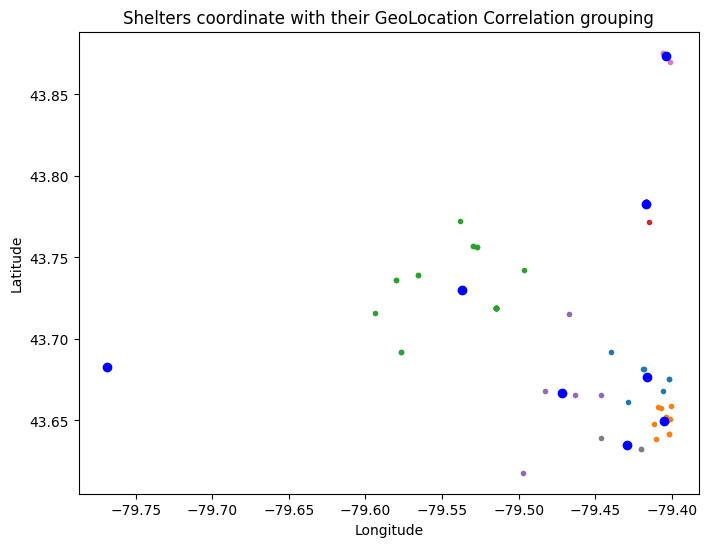

In [ ]:
plot_corr_grouping(corr_grouping_plot, cens_x, cens_y)

### Convert Dataset to Dataloader

With the proper dataframe, we will need to convert the dataset into a timeseries and then dataloader to feed into the model for training. Differing than other implementations, the Dataloader will also need to include extra features for the one hot encoder. This function below is to grab the scaler to scale the dataset

In [ ]:
def get_scaler():
    scaler = MinMaxScaler(feature_range = (-1, 1))
    return scaler

This model implementation is ofcourse a multivariate lstm. The features demonstrated here will be OCCUPANCY_DATE, Max Temp (Â°C),OCCUPIED_PERCENTAGE.

In [ ]:
used_features = ['OCCUPANCY_DATE', 'Max Temp (Â°C)', 'OCCUPIED_PERCENTAGE']


Differing than the Univariate, we will have to check if all features have all of their values filled in. If not we must manually fill it in by taking the average of the existing data. The function below accomplishes that.

In [ ]:
def feature_check(df):
    df_ = dc(df)
    for i in df_.columns:
        if df_[i].isna().any():
            avg = df_[i].mean()
            df_.loc[:, i] = df_[i].fillna(avg)
    return df_

To Convert the dataset into a dataloader, we will need to define a Dataset class for the time series

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

This function below will convert the dataframe to a time series for the model with proper hyperparameters as inputs

In [ ]:
def time_series_one_hot_converter(iso_data, shel_group, scaler, n_past, n_future, train_test_split, batch_size, used_features):

    train_x = []
    train_y = []

    one_hot_len = max(shel_group.values()) + 1

    num_feat = len(used_features) - 1 + one_hot_len

    dfs = []

    #Iterate through all useable Shelters
    for i in shel_group:

        #Getting the df from Iso Data
        df = dc(iso_data[int(i)])

        #Unifying the df to have the same output column name
        if df['OCCUPANCY_RATE_ROOMS'].isna().all():
            df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
        else:
            df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

        df = df[used_features]

        df = feature_check(df)

        for z in range(one_hot_len):
            if shel_group[i] == z:
                df['Feature_' + str(z)] = 1
            else:
                df['Feature_' + str(z)] = 0

        dfs.append(df)

    #Concatenating all Dfs together
    concatenated_df = pd.concat(dfs, ignore_index=True)

    #Isolate the feature columns
    iso_col = concatenated_df[['Feature_' + str(i) for i in range(one_hot_len)]]

    #Scaled the dfs
    scaler = scaler.fit(concatenated_df[used_features[1:]])
    np_df = scaler.fit_transform(concatenated_df[used_features[1:]])
    df_scaled = pd.DataFrame(np_df, columns=used_features[1:])

    #Combined the final df together
    np_df = pd.concat([iso_col, df_scaled], axis=1).values

    #Converting it into a time series
    for i in range(n_past, len(np_df) - n_future + 1):
        train_x.append(np_df[i - n_past: i, 0:np_df.shape[1]])
        train_y.append(np_df[i: i + n_future, - 1])

    train_x, train_y = np.array(train_x), np.array(train_y)

    split_index = int(len(train_x) * train_test_split)

    X_train = train_x[:split_index]
    X_test = train_x[split_index:]

    Y_train = train_y[:split_index]
    Y_test = train_y[split_index:]

    X_train_ = X_train.reshape((-1, n_past, num_feat))
    X_test_ = X_test.reshape((-1, n_past, num_feat))

    X_train = torch.tensor(X_train).float()
    Y_train = torch.tensor(Y_train).float()
    X_test = torch.tensor(X_test).float()
    Y_test = torch.tensor(Y_test).float()

    train_Dataset = TimeSeriesDataset(X_train, Y_train)
    test_Dataset = TimeSeriesDataset(X_test, Y_test)

    train_loader = DataLoader(train_Dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_Dataset, batch_size = batch_size, shuffle = True)

    return train_loader, test_loader, pd.concat([iso_col, df_scaled], axis=1)

To create the timeseries for the model, we will have to define certain hyperparameters such as the number of steps we will be looking back at, the number of steps we will be looking into the future, our batch size, and the train test split ratio.

In [ ]:
n_steps = 90
n_future = 60
batch_size = 16
train_test_split = 0.75
scaler = get_scaler()

Running the time_series_one_hot_converter function will convert the dataset into the dataloader.

In [ ]:
train_loader, test_loader, df_final = time_series_one_hot_converter(iso_data, shel_grouping(cens_index_dist_map[4]).copy(), scaler, n_steps, n_future, train_test_split, batch_size, used_features)

For a reference, this is what the data looks like that will be converted into a time-series with type dataloader. Notice that 4 new features have now been added to the dataframes, where 3 of the 4 new features are 0's with only 1 feature having a value of 1 for the one hot encoding. This Dataframe is for the distortions grouping scheme, This is apparent as there are only 4 new features for the one hot encoding instead of 8.

In [ ]:
display(df_final)

,Feature_0,Feature_1,Feature_2,Feature_3,Max Temp (Â°C),OCCUPIED_PERCENTAGE
0,0,0,0,1,-0.376033,0.971831
1,0,0,0,1,-0.388430,0.971831
2,0,0,0,1,-0.392562,0.971831
3,0,0,0,1,-0.409091,0.971831
4,0,0,0,1,-0.413223,0.971831
...,...,...,...,...,...,...
51642,0,1,0,0,-0.475207,0.971831
51643,0,1,0,0,-0.570248,0.971831
51644,0,1,0,0,-0.359504,0.971831
51645,0,1,0,0,-0.458678,0.971831


### Define the Model

Before training can begin, we will have to define the model architecture. Since the model is an lstm, it will contain LSTM architectures and also fully connected layers for the final output result. Please see the infrastructure below:

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Define the LSTM layers
        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size, hidden_size, batch_first=True)])
        for _ in range(1, num_stacked_layers):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))

        # Define the fully connected layers
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size)])
        self.fc_layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        batch_size = x.size(0)
        out = x

        # Initialize hidden state and cell state tensors for each LSTM layer
        hidden_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]
        cell_states = [torch.zeros(1, batch_size, self.hidden_size) for _ in range(self.num_stacked_layers)]

        # Pass input through each LSTM layer
        for lstm_layer, h0, c0 in zip(self.lstm_layers, hidden_states, cell_states):
            out, _ = lstm_layer(out, (h0, c0))

        # Apply fully connected layers
        out = self.fc_layers[0](out[:, -1, :])  # Apply the first fully connected layer
        out = torch.relu(out)  # Apply ReLU activation function
        for fc_layer in self.fc_layers[1:]:
            out = fc_layer(out)

        return out

The training code for the model can be found in the function below.

In [ ]:
def begin_training(model,num_epochs, train_loader, test_loader, loss, optimizer):

    training_loss = []
    validation_loss = []
    average_validation_loss = []
    for epoch in range(num_epochs):

        #Training
        model.train(True)
        running_loss = 0
        if epoch % 5 == 0:
          print("Epoch: " + str(epoch))

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0], batch[1]
            output        = model(x_batch)
            loss_         = loss(output, y_batch)
            running_loss += loss_.item()

            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

        if epoch % 5 == 0:
          print("Training Loss: " + str(running_loss))
        training_loss.append(running_loss)

        #Validating
        model.train(False)
        vad_loss = 0

        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0], batch[1]

            with torch.no_grad():
                output    = model(x_batch)
                loss_     = loss(output, y_batch)
                vad_loss += loss_.item()

        validation_loss.append(vad_loss)
        avg_loss_across_batches = vad_loss / len(test_loader)
        average_validation_loss.append(avg_loss_across_batches)
        if epoch % 5 == 0:
          print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
          print('***************************************************')
          print('\n')


    return model, training_loss, validation_loss, average_validation_loss

### Model Implementation One: Distortion Grouping Schema

We have demonstrated 2 different grouping schemas. We will now show the model training process of those 2 schemas and their results.

Define Model Hyperameters

In [ ]:
learning_rate = 1e-3
num_epochs = 25
train_test_split = 0.8
loss_function = nn.MSELoss()
input_size = len(used_features) + max(shel_grouping(cens_index_dist_map[4]).copy().values())
hidden_size = 120
num_stacked_layers = 2
output_size = n_future

Initialize the Model and Optimizers

In [ ]:
model = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

Begin training by activating the training function

In [ ]:
model, training_loss, valid_loss, avg_valid_loss = begin_training(model, num_epochs, train_loader, test_loader, loss_function, optimizer)

Epoch: 0
Training Loss: 88.12899401970208
Val Loss: 0.019
***************************************************


Epoch: 5
Training Loss: 67.8828636923572
Val Loss: 0.020
***************************************************


Epoch: 10
Training Loss: 61.67641365993768
Val Loss: 0.021
***************************************************


Epoch: 15
Training Loss: 53.2192036928609
Val Loss: 0.024
***************************************************


Epoch: 20
Training Loss: 41.19973006576765
Val Loss: 0.025
***************************************************




### Model Implementation One: Post Training Analysis

After training is done, the model can be accessed by looking at its training accuracies, losses, and also visual evaluations of how the model infer data on general toronto city wide dataset and also random shelters.

In [ ]:
def plot_errors(training_loss, valid_loss, avg_valid_loss):
	epochs = [i for i in range(1, len(training_loss) + 1)]
	fig, axs = plt.subplots(1, 3, figsize=(12, 3))
	axs[0].plot(epochs, training_loss)
	axs[1].plot(epochs, valid_loss)
	axs[2].plot(epochs, avg_valid_loss)

	axs[0].set_title('Training Loss')
	axs[0].set_xlabel('Epoch')
	axs[0].set_ylabel('Error')

	axs[1].set_title('Validation Loss')
	axs[1].set_xlabel('Epoch')
	axs[1].set_ylabel('Error')

	axs[2].set_title('Average Validation Loss Per Batch')
	axs[2].set_xlabel('Epoch')
	axs[2].set_ylabel('Error')
	plt.tight_layout()
	plt.show()

Calling that function will get us the Error graph

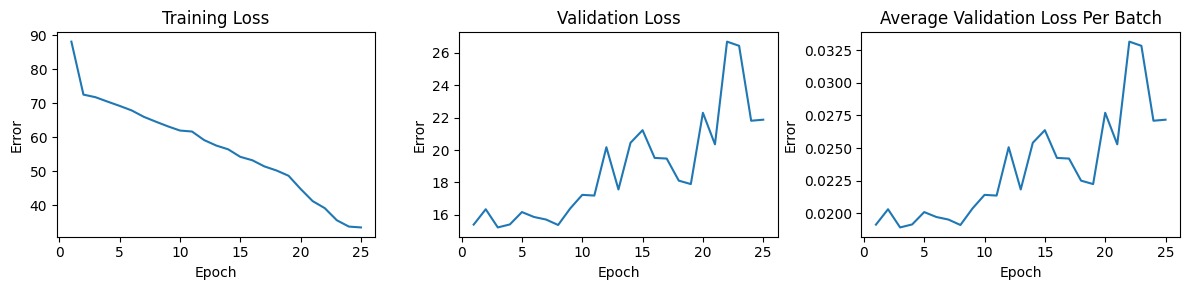

In [ ]:
plot_errors(training_loss, valid_loss, avg_valid_loss)

We will now see the model's performance on predicting on random shelters. We can no longer view the Toronto General Dataset due to the fact that we cannot encode that data since it is the data of the of the whole city, and does not belong to any grouping. The function below is for inferring future dates given the model and dataframe.

In [ ]:
def infer_date_(model, df, scaler, n_future, future_days = None, one_hot_feature = None):

    #one_hot_feature guide
    #0: Index of 1's
    #1: Length of Vector

    #Set model training to False
    model.train(False)
    copy_df = dc(df)

    #Case 1: if model predicts multiple days at once
    if n_future > 1:

        #Build Dateframe for future days
        max_date = df['OCCUPANCY_DATE'].max()
        date_range = pd.date_range(start=max_date, end=max_date + pd.Timedelta(days=n_future), freq = 'D')
        df_new = pd.DataFrame({'OCCUPANCY_DATE': date_range})

        #Scaling input Dataframe
        copy_df.set_index('OCCUPANCY_DATE', inplace = True)
        df_scaled = scaler.fit_transform(copy_df)

        if one_hot_feature is not None:
            for i in range(one_hot_feature[1]):

                if i != one_hot_feature[0]:
                    arr = np.zeros((df_scaled.shape[0], 1))
                    df_scaled = np.hstack((arr, df_scaled))
                else:
                    arr = np.ones((df_scaled.shape[0], 1))
                    df_scaled = np.hstack((arr, df_scaled))

        #Convert data to tensor and passing it into the model to get predicted data and converting it into a panda dataframe before returning it
        y = model(torch.tensor(df_scaled).unsqueeze(0).float()).detach().numpy().reshape(-1,1)
        y_ = np.repeat(y, copy_df.shape[1], axis = -1)
        y_actual = scaler.inverse_transform(y_)[:,-1]
        y_inserted = np.insert(y_actual, 0, df['OCCUPIED_PERCENTAGE'].iloc[-1])
        df_new['OCCUPIED_PERCENTAGE'] = pd.DataFrame(y_inserted, columns = ['OCCUPIED_PERCENTAGE'])


    #Case 2: if model predicts one day at a time; therefore need loop to predict all future_days days.
    if n_future == 1 and future_days is not None:

        data = torch.tensor(scaler.fit_transform(np.array(copy_df['OCCUPIED_PERCENTAGE']).reshape(-1, 1)).reshape((-1, copy_df.shape[0], 1))).float()
        for i in range(future_days):
            y = model(data).unsqueeze(0)
            data = torch.cat((data, y), dim = 1)
        data = scaler.inverse_transform(data.squeeze().detach().numpy().reshape(-1, 1)).flatten()

        #Adding a data column to the new data
        max_date = copy_df['OCCUPANCY_DATE'].max()
        date_range = pd.date_range(start=max_date , end=max_date + pd.Timedelta(days=future_days), freq = 'D')
        df_new = pd.DataFrame({'OCCUPANCY_DATE': date_range})

        #Getting the newly generated portion of data
        new_data = data[-future_days:]
        new_data = np.insert(new_data, 0, copy_df['OCCUPIED_PERCENTAGE'].iloc[-1])
        new_data_df = pd.DataFrame(new_data, columns = ['OCCUPIED_PERCENTAGE'])

        #Combined
        df_new['OCCUPIED_PERCENTAGE'] = new_data_df

    return df_new

The function below that is to create the graph itself

In [ ]:
def plot_random_shelters_one_hot(model, iso_data, n_future, num_sq, scaler, used_features, shel_group, test_check = False, future_days = None):

	random_keys = random.sample(list(shel_group), num_sq ** 2)
	fig, axs = plt.subplots(num_sq, num_sq, figsize=(11, 8))
	for i in range(num_sq):
		for j in range(num_sq):

			shelter_index = random_keys[i * num_sq + j]  # Calculate the index from the 1D array

			#Preprocess the iso by copying it into local variables to avoid changing the iso_data itself
			df_use = dc(iso_data[shelter_index])
			max_date = df_use['OCCUPANCY_DATE'].max()

			if df_use['OCCUPANCY_RATE_ROOMS'].isna().all():
				df_use = df_use.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
			else:
				df_use = df_use.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

			df_infer = df_use[used_features]

			df_infer = feature_check(df_infer)

			#If test check, move the data back by n_future days inorder to view model's performance
			if test_check:

				if future_days is None:
					use_date = max(df_use['OCCUPANCY_DATE']) - pd.Timedelta(days = n_future)
					df_infer = df_infer[df_infer['OCCUPANCY_DATE'] <= use_date]

				elif future_days is not None:
					use_date = max(df_use['OCCUPANCY_DATE']) - pd.Timedelta(days = future_days)
					df_infer = df_infer[df_infer['OCCUPANCY_DATE'] <= use_date]

			try:

				df = infer_date_(model, df_infer, scaler, n_future, future_days, [shel_group[shelter_index], max(shel_group.values()) + 1])

				axs[i, j].plot(df_use['OCCUPANCY_DATE'], df_use['OCCUPIED_PERCENTAGE'])
				axs[i, j].plot(df['OCCUPANCY_DATE'], df['OCCUPIED_PERCENTAGE'])

				#Labeling
				axs[i, j].set_title(f'Shelter {shelter_index}')
				axs[i, j].set_xlabel('Date')
				axs[i, j].set_ylabel('Occupied Percentage (%)')

			except Exception as e:
				print("Error: " + str(e))

	plt.tight_layout()
	plt.show()

Before we call the function, we will need to eliminate any incompatible shelters.

In [ ]:
for i in iso_data.copy():
  if iso_data[i].shape[0] <= n_steps - 1:
    del iso_data[i]

Calling this function to get the graph showing inference on random shelters

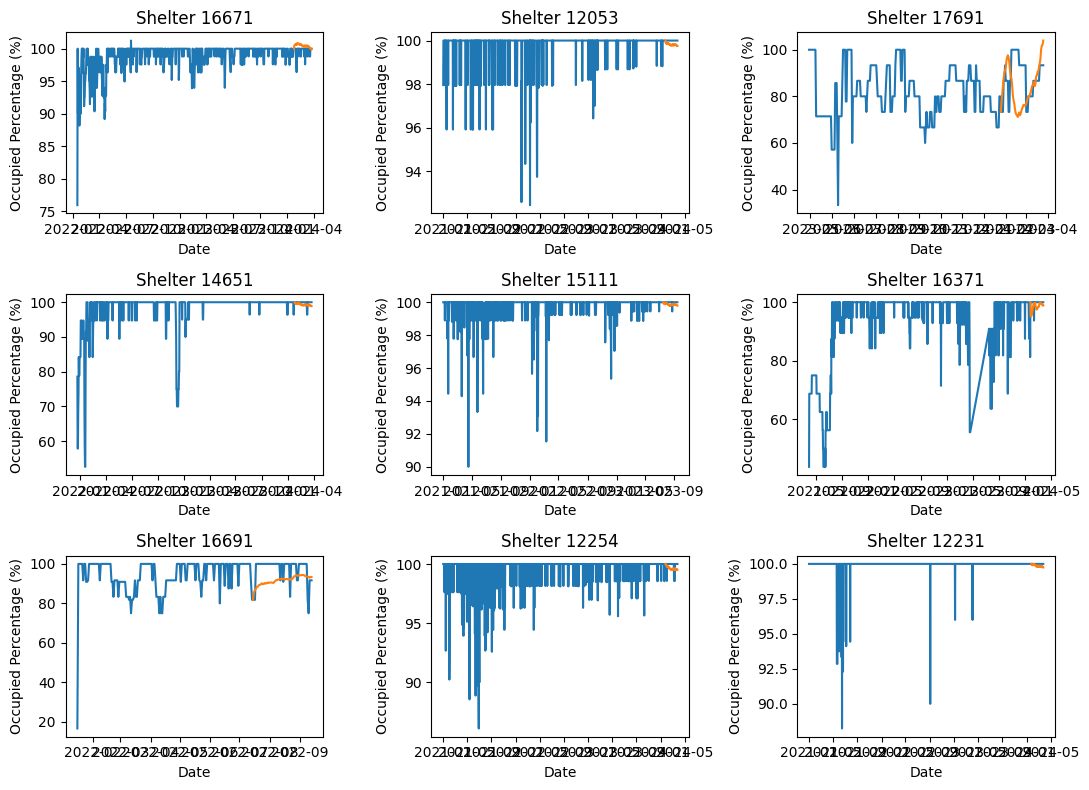

In [ ]:
test_check = True
num_sq = 3
plot_random_shelters_one_hot(model, iso_data, n_future, num_sq, scaler, used_features, shel_grouping(cens_index_dist_map[4]).copy(), test_check)

Lets calculate the loss by asking model to infer data on the 5 predetermind shelters then we can calculate the mae rmse. First lets select the 5 shelters.

In [ ]:
#Reduce iso_data to just the 5 shelters being used for testing
shelters_test = [11794, 11831, 12252, 12254, 12274]
test_data = iso_data.copy()
for i in iso_data.copy():
  if i not in shelters_test:
    del test_data[i]

The function below calculates the loss of the model.

In [ ]:
def calc_loss(model, iso_data, used_features, shel_grouping = None):
  #Initialize the Loss variables
  total_shel = 0
  loss_ = 0

  total_shel_ = 0
  loss_sq = 0

  for i in iso_data:

    if len(iso_data[i]) > 60:
      df = iso_data[i]

      #Rename the columns
      if df['OCCUPANCY_RATE_ROOMS'].isna().all():
        df = df.rename(columns = {'OCCUPANCY_RATE_BEDS': 'OCCUPIED_PERCENTAGE'})
      else:
        df = df.rename(columns = {'OCCUPANCY_RATE_ROOMS': 'OCCUPIED_PERCENTAGE'})

      #Selecting on used features
      df = df[used_features]

      df = feature_check(df)

      #Move the dates back by 60 days
      df_use_infer = dc(df)
      use_date = max(df_use_infer['OCCUPANCY_DATE']) - pd.Timedelta(days = 60)
      df_use_infer = df_use_infer[df_use_infer['OCCUPANCY_DATE'] <= use_date]

      #Inferring Data
      if shel_grouping is None:
        df_infer = infer_date_(model, df_use_infer, scaler, n_future, future_days = 60, one_hot_feature = None)
        df_infer_date = min(df_infer['OCCUPANCY_DATE'])
        df_infer = df_infer[df_infer['OCCUPANCY_DATE'] > df_infer_date]
      else:
        df_infer = infer_date_(model, df_use_infer, scaler, n_future, future_days = 60, one_hot_feature = [shel_grouping[i], max(shel_grouping.values()) + 1])
        df_infer_date = min(df_infer['OCCUPANCY_DATE'])
        df_infer = df_infer[df_infer['OCCUPANCY_DATE'] > df_infer_date]

      #data used for loss calculations
      df_loss = dc(df)
      df_loss = df_loss[df_loss['OCCUPANCY_DATE'] > use_date]

      #Calculating Loss
      df_np = df_loss['OCCUPIED_PERCENTAGE'].values
      df_np_infer = df_infer['OCCUPIED_PERCENTAGE'].values

      temp_loss = 0
      temp_loss_sq = 0
      for i in range(len(df_np)):
        temp_loss += abs(df_np[i] - df_np_infer[i])
        temp_loss_sq += abs(df_np[i] - df_np_infer[i]) ** 2
      if temp_loss > 0:
        total_shel += 1
        loss_ += temp_loss
      if temp_loss_sq > 0:
        total_shel_ += 1
        loss_sq += temp_loss_sq
      loss_ /= 60
      loss_sq /= 60
      loss_sq = loss_sq ** (1/2)


  avg_loss = loss_/total_shel
  avg_loss_sq = loss_sq/total_shel_
  return avg_loss, avg_loss_sq

Call the function to get the loss

In [ ]:
loss, loss_sq = calc_loss(model, test_data.copy(), used_features, shel_grouping(cens_index_dist_map[4]).copy())
print("MAE Loss: " + str(loss))
print("MRSE Loss: " + str(loss_sq))

MAE Loss: 0.43137724650530834
MRSE Loss: 0.436330943288693


###Model Implementation Two: Correlation Grouping Schema

This is the second implementation of the 2 grouping schemas. This implementation is for the Correlation Grouping Schema

Build dataloader and test loader

In [ ]:
train_loader_2, test_loader_2, df_final_2 = time_series_one_hot_converter(iso_data, shel_grouping(cens_index_corr_map[8]).copy(), scaler, n_steps, n_future, train_test_split, batch_size, used_features)

Define Model Hyperparameters

In [ ]:
learning_rate = 1e-3
num_epochs = 25
train_test_split = 0.8
loss_function = nn.MSELoss()
input_size = len(used_features) + max(shel_grouping(cens_index_corr_map[8]).copy().values())
hidden_size = 120
num_stacked_layers = 2
output_size = n_future

Initialize the Model and Optimizers

In [ ]:
model_2 = LSTM(input_size, hidden_size, num_stacked_layers, output_size)
optimizer_2 = torch.optim.AdamW(model_2.parameters(), lr = learning_rate)

Begin training by activating the training function

In [ ]:
model_2, training_loss_2, valid_loss_2, avg_valid_loss_2 = begin_training(model_2, num_epochs, train_loader_2, test_loader_2, loss_function, optimizer_2)

Epoch: 0
Training Loss: 87.90906933043152
Val Loss: 0.023
***************************************************


Epoch: 5
Training Loss: 67.73424402379896
Val Loss: 0.023
***************************************************


Epoch: 10
Training Loss: 59.31116504519014
Val Loss: 0.023
***************************************************


Epoch: 15
Training Loss: 50.0959992876742
Val Loss: 0.025
***************************************************


Epoch: 20
Training Loss: 43.43651357793715
Val Loss: 0.027
***************************************************




### Model Implementation Two: Post Training Analysis

After training is done, the model can be accessed by looking at its training accuracies, losses, and also visual evaluations of how the model infer data on general toronto city wide dataset and also random shelters. We will start of with graphing error graph.

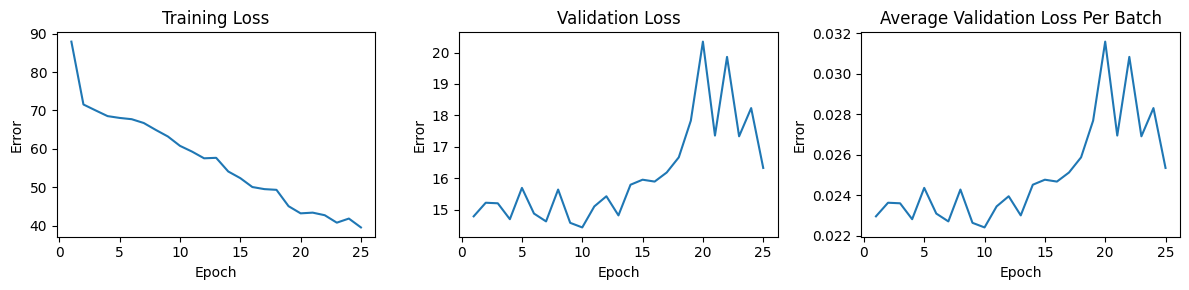

In [ ]:
plot_errors(training_loss_2, valid_loss_2, avg_valid_loss_2)


Calling this function to get the graph showing inference on random shelters

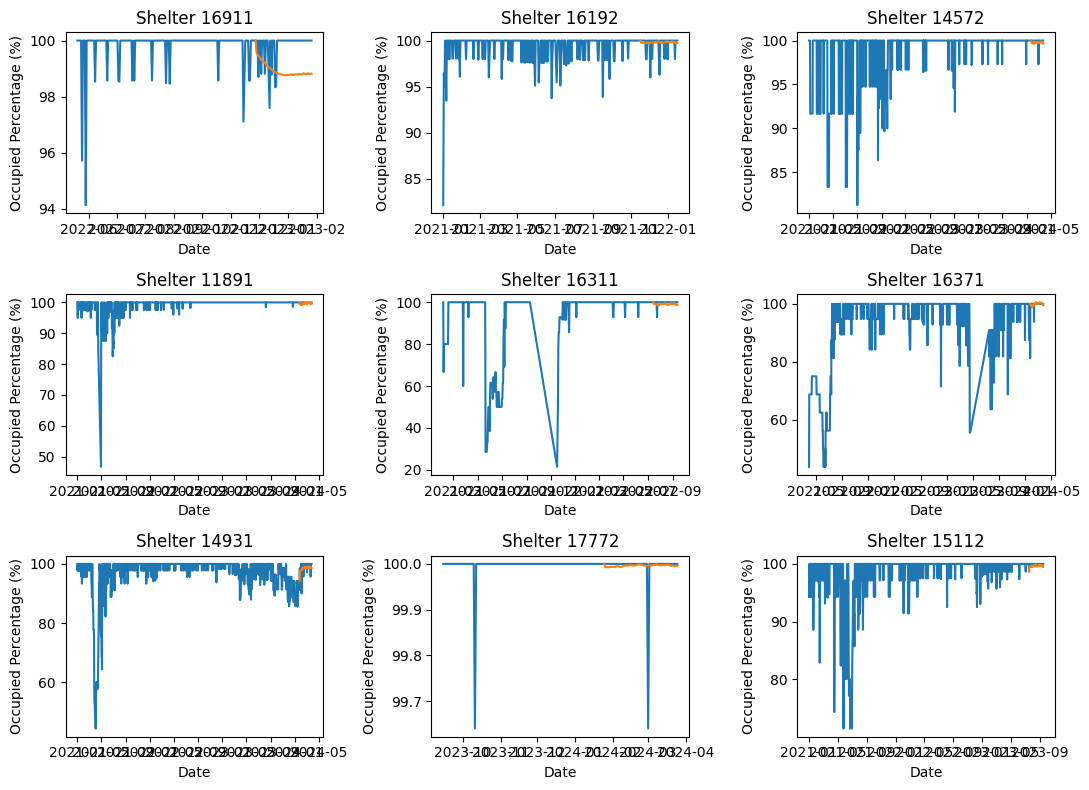

In [ ]:
test_check = True
num_sq = 3
plot_random_shelters_one_hot(model_2, iso_data, n_future, num_sq, scaler, used_features, shel_grouping(cens_index_corr_map[8]).copy(), test_check)

Call the function to get the loss

In [ ]:
loss, loss_sq = calc_loss(model_2, test_data.copy(), used_features, shel_grouping(cens_index_corr_map[8]).copy())
print("MAE Loss: " + str(loss))
print("MRSE Loss: " + str(loss_sq))

MAE Loss: 0.11040867571382404
MRSE Loss: 0.11634771365171966
